# This file process 3 .txt files taked from the British Geological Survey about Ground-Water and save it as a CSV.

### First we make explicit the installation of libraries we will use and the importing.

In [1]:
!pip3 install -q --upgrade pip
!pip3 install -q pandas numpy matplotlib seaborn openpyxl climateserv requests netCDF4 xarray pyproj

In [2]:
import os
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

import sys
from pathlib import Path

# Calculate the path to the scripts folder relative to the current notebook.
scripts_dir = Path("../../").resolve()

# Add the scripts directory to the sys.path if it's not already there.
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import pandas as pd
from scripts.preprocessing.british_geological_survey import find_closest_points

### We have data in 3 different .txt files, we will combine them, and save just the data inside the Gambia Boundaries (Latitud and Longitud)

In [3]:
# Define the bounding box for The Gambia
GAMBIA_BOUNDARIES = {
    "min_lat": 13.052113101601,  # Lower latitude
    "max_lat": 13.837920583180,  # Upper latitude
    "min_lon": -17.06499856438,  # More western longitude
    "max_lon": -13.77921401885   # More eastern longitude
}


def filter_gambia_points(file_path: str) -> pd.DataFrame:
    """
    Read the ASCII file and filter points that are within The Gambia's boundaries.
    """
    df = pd.read_csv(file_path, delim_whitespace=True)
    # Filter based on The Gambia's bounding box
    df = df[(df['X'] >= GAMBIA_BOUNDARIES['min_lon']) & (df['X'] <= GAMBIA_BOUNDARIES['max_lon']) &
            (df['Y'] >= GAMBIA_BOUNDARIES['min_lat']) & (df['Y'] <= GAMBIA_BOUNDARIES['max_lat'])]
    return df

def map_values_to_description(df: pd.DataFrame, value_key: str, mapping_dict: dict) -> pd.DataFrame:
    """
    Maps the ASCII values in the DataFrame to their descriptions using the provided mapping dictionary.
    """
    df[value_key] = df[value_key].map(mapping_dict)
    return df

def round_coordinates(df, precision=3):
    """
    Round the X and Y coordinates to the specified precision.
    
    Parameters:
    df (pd.DataFrame): DataFrame with the X and Y columns.
    precision (int): Decimal places to round to.

    Returns:
    pd.DataFrame: DataFrame with rounded coordinates.
    """
    df['X'] = df['X'].round(precision)
    df['Y'] = df['Y'].round(precision)
    return df

# Depth to Groundwater mapping
depth_to_groundwater_mapping = {
    'VS': '0-7', 'S': '7-25', 'SM': '25-50', 'M': '50-100', 'D': '100-250', 'VD': '>250'
}

# Groundwater Productivity mapping
groundwater_productivity_mapping = {
    'VH': '>20', 'H': '5-20', 'M': '1-5', 'LM': '0.5-1', 'L': '0.1-0.5', 'VL': '<0.1'
}

# Groundwater Storage mapping
groundwater_storage_mapping = {
    '0': '0', 'L': '<1000', 'LM': '1000-10,000', 'M': '10,000-25,000', 'H': '25,000-50,000', 'VH': '>50,000'
}

# Paths to the data files
depth_to_groundwater_file = '../data/original_data/british_geological_survey_africa/DepthToGroundwater_V2/xyzASCII_dtwmap_v2.txt'
groundwater_productivity_file = '../data/original_data/british_geological_survey_africa/GroundwaterProductivity/xyzASCII_gwprod_v1.txt'
groundwater_storage_file = '../data/original_data/british_geological_survey_africa/GroundwaterStorage/xyzASCII_gwstor_v1.txt'


# Read and process the Depth to Groundwater data
df_dtw = filter_gambia_points(file_path=depth_to_groundwater_file)
df_dtw = map_values_to_description(df=df_dtw, value_key='DTWAFRICA_', mapping_dict=depth_to_groundwater_mapping)
df_dtw.rename(columns={'DTWAFRICA_': 'DepthToGroundwater'}, inplace=True)

# Read and process the Groundwater Productivity data
df_gwprod = filter_gambia_points(file_path=groundwater_productivity_file)
df_gwprod = map_values_to_description(df=df_gwprod, value_key='GWPROD_V2', mapping_dict=groundwater_productivity_mapping)
df_gwprod.rename(columns={'GWPROD_V2': 'GroundwaterProductivity'}, inplace=True)

# Read and process the Groundwater Storage data
df_gwstor = filter_gambia_points(file_path=groundwater_storage_file)
df_gwstor = map_values_to_description(df=df_gwstor, value_key='GWSTOR_V2', mapping_dict=groundwater_storage_mapping)
df_gwstor.rename(columns={'GWSTOR_V2': 'GroundwaterStorage'}, inplace=True)


# Apply the rounding to each DataFrame before merging
precision = 3
df_dtw = round_coordinates(df_dtw, precision=precision)
df_gwprod = round_coordinates(df_gwprod, precision=precision)
df_gwstor = round_coordinates(df_gwstor, precision=precision)

# Now combine the dataframes
combined_df = df_dtw.merge(df_gwprod, on=['X', 'Y'], how='outer').merge(df_gwstor, on=['X', 'Y'], how='outer')

folder_path = '../data/processed_data/british_geological_survey_africa/'
# Define the path to the folder where you want to save the CSV file

# Ensure the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the name of the CSV file
csv_file_name = 'combined_data.csv'

# Construct the full path to the CSV file
combined_csv_path = folder_path + csv_file_name

# Save the combined data to the CSV file
combined_df.to_csv(combined_csv_path, index=False)

print(f"Combined data saved to {combined_csv_path}")


Combined data saved to processed_data/combined_data.csv


### We combine the data even more, in threshold of 0.001 degrees something similar as a 1 kilometer radius. 

In [8]:
# Load your data
df = pd.read_csv('../data/processed_data/british_geological_survey_africa/combined_data.csv')

# Define the rounding precision based on the desired range for grouping
# For example, 0.03 would group points that are within ~3km of each other
grouping_threshold = 0.001

# Round the coordinates to the nearest grouping threshold
df['X_rounded'] = (df['X'] / grouping_threshold).round() * grouping_threshold
df['Y_rounded'] = (df['Y'] / grouping_threshold).round() * grouping_threshold

# Now group by these rounded coordinates
grouped = df.groupby(['X_rounded', 'Y_rounded'])

# Define an aggregation function that takes the most frequent non-null value
def most_frequent_non_null(series):
    if series.isnull().all():
        return None
    else:
        return series.dropna().mode().iloc[0]

# Aggregate your data
aggregated_df = grouped.agg({
    'X': 'first',  # Keep the first X value
    'Y': 'first',  # Keep the first Y value
    'DepthToGroundwater': most_frequent_non_null,
    'GroundwaterProductivity': most_frequent_non_null,
    'GroundwaterStorage': most_frequent_non_null
}).reset_index(drop=True)

# Save the aggregated data back to CSV
aggregated_df.to_csv('processed_data/combined_data_aggregated.csv', index=False)

print(f"Aggregated data saved to combined_data_aggregated.csv")


Aggregated data saved to combined_data_aggregated.csv


### We create a code to see how de data its. We have many NaNs between variables? 

In [9]:
# Load the aggregated data
df = pd.read_csv('processed_data/combined_data_aggregated.csv')

# Calculate the total number of rows
total_rows = len(df)

# Calculate the number of rows with all values present
full_values = df.dropna().shape[0]

# Calculate the number of rows with missing values
missing_values = total_rows - full_values

# Calculate the number of rows with only the first value present
only_first = df[df['GroundwaterProductivity'].isna() & df['GroundwaterStorage'].isna()].shape[0]

# Calculate the number of rows with only the second value present
only_second = df[df['DepthToGroundwater'].isna() & df['GroundwaterStorage'].isna()].shape[0]

# Calculate the number of rows with only the third value present
only_third = df[df['DepthToGroundwater'].isna() & df['GroundwaterProductivity'].isna()].shape[0]

# Calculate the number of rows with the first and second values present but missing third
first_and_second = df[df['GroundwaterStorage'].isna() & df['DepthToGroundwater'].notna() & df['GroundwaterProductivity'].notna()].shape[0]

# Calculate the number of rows with the second and third values present but missing first
second_and_third = df[df['DepthToGroundwater'].isna() & df['GroundwaterProductivity'].notna() & df['GroundwaterStorage'].notna()].shape[0]

# Calculate the number of rows with the first and third values present but missing second
first_and_third = df[df['GroundwaterProductivity'].isna() & df['DepthToGroundwater'].notna() & df['GroundwaterStorage'].notna()].shape[0]

# Print the results
print(f"Total rows: {total_rows}")
print(f"Rows with all values: {full_values}")
print(f"Rows with any missing values: {missing_values}")
print(f"Rows with only the first value: {only_first}")
print(f"Rows with only the second value: {only_second}")
print(f"Rows with only the third value: {only_third}")
print(f"Rows with the first and second values, but missing third: {first_and_second}")
print(f"Rows with the second and third values, but missing first: {second_and_third}")
print(f"Rows with the first and third values, but missing second: {first_and_third}")


Total rows: 2671
Rows with all values: 0
Rows with any missing values: 2671
Rows with only the first value: 933
Rows with only the second value: 826
Rows with only the third value: 912
Rows with the first and second values, but missing third: 0
Rows with the second and third values, but missing first: 0
Rows with the first and third values, but missing second: 0


### We see that the data its still not merged, so we create a Nearest Neighbors to populated the data where its empty. So basically for each empty point, we see the 5 closest points with data, and the most mode data, we copy in the empty point

In [21]:
# Load the data
df = pd.read_csv('processed_data/combined_data_aggregated.csv')

# Fill missing values with empty strings for easier processing
df.fillna('', inplace=True)

# Initialize NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(df[['X', 'Y']])

def impute_column(df: pd.DataFrame, column_name: str, neigh: NearestNeighbors) -> None:
    """
    Impute missing values for a given column using the Nearest Neighbors algorithm.
    """
    needs_impute = df[df[column_name] == '']
    for index, row in needs_impute.iterrows():
        # Create a temporary DataFrame with the same columns used for fitting
        temp_df = pd.DataFrame([row[['X', 'Y']]], columns=['X', 'Y'])
        _, indices = neigh.kneighbors(temp_df)
        neighbor_values = df.iloc[indices[0]][column_name].values
        neighbor_values = [value for value in neighbor_values if value != '']
        if neighbor_values:
            most_common_value = pd.Series(neighbor_values).mode().iloc[0]
            df.at[index, column_name] = most_common_value

# Impute the required columns
columns_to_impute = ['DepthToGroundwater', 'GroundwaterProductivity', 'GroundwaterStorage']
for column in columns_to_impute:
    impute_column(df=df, column_name=column, neigh=neigh)

# Replace empty strings with NaN to maintain consistency
df.replace('', pd.NA, inplace=True)

# Save the filled data to a CSV file
df.to_csv('processed_data/combined_data_filled.csv', index=False)

### Now we see if the data its combined ready to use. 

In [22]:
# Load the aggregated data
df = pd.read_csv('processed_data/combined_data_filled.csv')

# Calculate the total number of rows
total_rows = len(df)

# Calculate the number of rows with all values present
full_values = df.dropna().shape[0]

# Calculate the number of rows with missing values
missing_values = total_rows - full_values

# Calculate the number of rows with only the first value present
only_first = df[df['GroundwaterProductivity'].isna() & df['GroundwaterStorage'].isna()].shape[0]

# Calculate the number of rows with only the second value present
only_second = df[df['DepthToGroundwater'].isna() & df['GroundwaterStorage'].isna()].shape[0]

# Calculate the number of rows with only the third value present
only_third = df[df['DepthToGroundwater'].isna() & df['GroundwaterProductivity'].isna()].shape[0]

# Calculate the number of rows with the first and second values present but missing third
first_and_second = df[df['GroundwaterStorage'].isna() & df['DepthToGroundwater'].notna() & df['GroundwaterProductivity'].notna()].shape[0]

# Calculate the number of rows with the second and third values present but missing first
second_and_third = df[df['DepthToGroundwater'].isna() & df['GroundwaterProductivity'].notna() & df['GroundwaterStorage'].notna()].shape[0]

# Calculate the number of rows with the first and third values present but missing second
first_and_third = df[df['GroundwaterProductivity'].isna() & df['DepthToGroundwater'].notna() & df['GroundwaterStorage'].notna()].shape[0]

# Print the results
print(f"Total rows: {total_rows}")
print(f"Rows with all values: {full_values}")
print(f"Rows with any missing values: {missing_values}")
print(f"Rows with only the first value: {only_first}")
print(f"Rows with only the second value: {only_second}")
print(f"Rows with only the third value: {only_third}")
print(f"Rows with the first and second values, but missing third: {first_and_second}")
print(f"Rows with the second and third values, but missing first: {second_and_third}")
print(f"Rows with the first and third values, but missing second: {first_and_third}")

Total rows: 2671
Rows with all values: 2647
Rows with any missing values: 24
Rows with only the first value: 14
Rows with only the second value: 0
Rows with only the third value: 0
Rows with the first and second values, but missing third: 0
Rows with the second and third values, but missing first: 0
Rows with the first and third values, but missing second: 10


### We can see above that now we have almost all the rows fully completed. We want to see the different variables in each column

In [29]:
# Load the aggregated data
df = pd.read_csv('processed_data/combined_data_filled.csv')

# Calculate the total number of rows
total_rows = len(df)

# [Your code to calculate the different categories of rows...]

# Print the previous results
print(f"Total rows: {total_rows}")
print(f"Rows with all values: {full_values}")  # Replace 'full_values' with your calculated value
print(f"Rows with any missing values: {missing_values}")  # Replace 'missing_values' with your calculated value
# [Print the rest of your row categories...]

# Obtain and print unique values for each column, except 'X' and 'Y'
for column in df.columns:
    if column not in ['X', 'Y']:
        unique_values = df[column].unique()
        print(f"Unique values in '{column}': {unique_values}")

Total rows: 2671
Rows with all values: 2647
Rows with any missing values: 24
Unique values in 'DepthToGroundwater': ['7-25' '0-7' '>250' '25-50']
Unique values in 'GroundwaterProductivity': [nan '>20']
Unique values in 'GroundwaterStorage': [nan '>50,000']


### Now we plot the Nearest Neighbors Algorithm and 5 examples of usage to easy understand how it work. 

/Users/franciscofurey/00DataScience/OpenAi/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/franciscofurey/00DataScience/OpenAi/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/franciscofurey/00DataScience/OpenAi/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/franciscofurey/00DataScience/OpenAi/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/franciscofurey/00DataScience/OpenAi/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature 

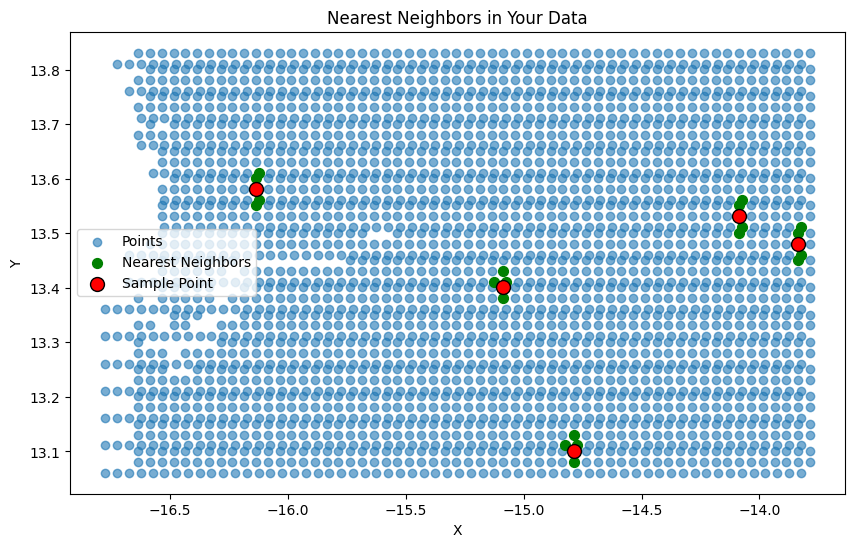

In [38]:
# Load the data
df = pd.read_csv('processed_data/combined_data_aggregated.csv')

# Fill missing values with empty strings for easier processing
df.fillna('', inplace=True)

# Initialize and train NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(df[['X', 'Y']])

# Visualization setup
plt.figure(figsize=(10, 6))

# Plot all points in blue first so that the red points overlay
plt.scatter(df['X'], df['Y'], label='Points', alpha=0.6, zorder=1)

# Select 5 random sample points that need imputation
# Assuming that missing values are represented by empty strings
missing_values_indices = df.index[df['DepthToGroundwater'] == ''].tolist()
sample_indices = np.random.choice(missing_values_indices, size=5, replace=False)

# For each sample point, find and visualize the nearest neighbors
for sample_index in sample_indices:
    sample_point = df.iloc[sample_index]
    # Find the 5 nearest neighbors for the sample point
    _, indices = neigh.kneighbors([sample_point[['X', 'Y']].values])  # Corrected to pass an array
    # Plot the nearest neighbors in green
    plt.scatter(df.iloc[indices[0]]['X'], df.iloc[indices[0]]['Y'], color='green', s=50, 
                label='Nearest Neighbors' if sample_index == sample_indices[0] else "", zorder=2)
    # Plot the sample point in red, larger and with an edge to highlight
    plt.scatter(sample_point['X'], sample_point['Y'], color='red', s=100, edgecolor='black', 
                label='Sample Point' if sample_index == sample_indices[0] else "", zorder=3)

plt.title('Nearest Neighbors in Your Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


### In this graph above we can see that for each point whit empty values (red ones), takes the 5 more closest points (green ones), and see his values inside. And the value with more repetead into the green dotes its populated inside into the red dot.

In [4]:
wells_updated_df = find_closest_points(
    wells_path='../../data/processed_data/igrac/wells_gambia.csv', 
    combined_data_path='../../data/processed_data/british_geological_survey_africa/combined_data_filled.csv'
)
wells_updated_df.to_csv('../../data/processed_data/igrac/wells_gambia_updated.csv', index=False)

/Users/franciscofurey/00DataScience/aquaViva/scripts/preprocessing/british_geological_survey.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0-7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  wells_df.at[index, 'DepthToGroundwater'] = combined_df.at[closest_idx, 'DepthToGroundwater']
/Users/franciscofurey/00DataScience/aquaViva/scripts/preprocessing/british_geological_survey.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '>20' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  wells_df.at[index, 'GroundwaterProductivity'] = combined_df.at[closest_idx, 'GroundwaterProductivity']
/Users/franciscofurey/00DataScience/aquaViva/scripts/preprocessing/british_geological_survey.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will 